<a href="https://colab.research.google.com/github/TimurMMD/speech-recognition-app/blob/main/Speech_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎧 Voice Dataset Preparation Notebook

Welcome! This Python notebook is dedicated to preparing multilingual voice datasets for training speech recognition models.  
The audio data has been sourced from [Common Voice](https://commonvoice.mozilla.org/en/datasets) by Mozilla, which provides open-source speech data in a variety of languages.  

In this notebook, we will:
- Clean and sort the metadata,
- Preprocess audio files from `.mp3` to `.wav`,
- Validate and align transcript and audio data,
- Split the datasets into training, validation, and test sets,  
to ensure everything is ready for machine learning model training.  

---

### 📂 Table of Contents

1. 📦 Import Libraries   
2. 🧹 Cleaning and Sorting  
3. 🎛️ Preprocessing Audio Files  
4. 🔍 Check Audio Order  
5. ❓ Find Missing Files
  
6. 🪄 Dataset Splitting

---

> ✅ By following these steps, you ensure your dataset is clean, properly aligned, and suitable for training robust voice models.

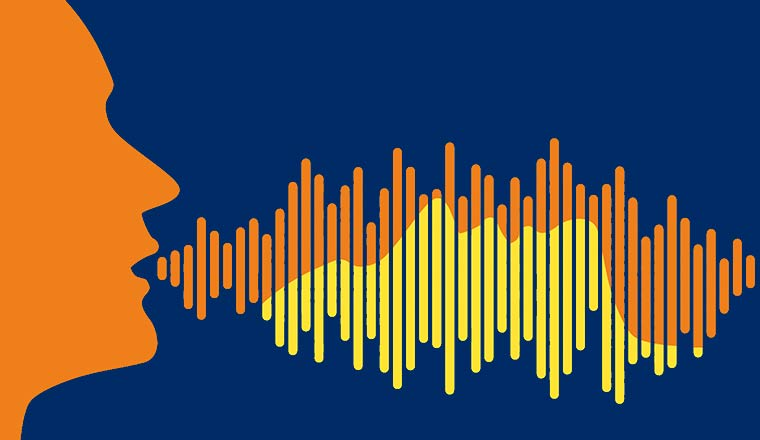

#📦 Import Libraries

In [ ]:
import pandas as pd
from pydub import AudioSegment
import os
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from pydub.silence import detect_nonsilent
from google.colab import drive
drive.mount('/content/drive')
!apt-get install -y ffmpeg
!pip install pydub


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## 🧹 Cleaning and Sorting

In [ ]:


def audio_dataset(url_data, url_mp3, url_wav, drive_output_folder):
    """
    Processes an audio dataset by:
    - Loading filenames and transcriptions
    - Matching .mp3 files
    - Converting them to .wav
    - Cleaning up unrelated files
    - Saving metadata and sorted lists to Drive
    - Returning sorted list of .wav files

    Parameters:
    - url_data: Path to the .tsv file with 'path' and 'sentence'
    - url_mp3: Path to folder with source .mp3 files
    - url_wav: Path to save converted .wav files
    - drive_output_folder: Folder in Google Drive to save outputs
    """

    # Step 1: Load and filter data
    data = pd.read_csv(url_data, sep="\t")
    data = data[['path', 'sentence']]
    data_list = data['path'].to_list()
    sorted_list = sorted(data_list)

    # Save filtered DataFrame and sorted list to Google Drive
    os.makedirs(drive_output_folder, exist_ok=True)
    data.to_csv(os.path.join(drive_output_folder, 'filtered_data.csv'), index=False)
    pd.DataFrame(sorted_list, columns=["sorted_paths"]).to_csv(os.path.join(drive_output_folder, 'sorted_list.csv'), index=False)
    print("📁 Saved filtered data and sorted list to Drive.")

    # Step 2: Prepare WAV folder
    os.makedirs(url_wav, exist_ok=True)
    wanted_files = [file for file in sorted_list if file.endswith('.mp3')]
    matched_files = [f for f in os.listdir(url_mp3) if f in wanted_files]

    # Step 3: Convert MP3 to WAV with progress bar
    print("🎧 Converting MP3 to WAV...")
    for file in tqdm(matched_files):
        mp3_path = os.path.join(url_mp3, file)
        wav_path = os.path.join(url_wav, file.replace(".mp3", ".wav"))
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")

    # Step 4: Cleanup unrelated .wav files
    allowed_files = {name.replace('.mp3', '.wav') for name in sorted_list}
    all_files = os.listdir(url_wav)

    for fname in all_files:
        if fname.endswith('.wav') and fname not in allowed_files:
            fpath = os.path.join(url_wav, fname)
            os.remove(fpath)
            print(f"🗑️ Deleted: {fname}")

    print("✅ Cleanup complete. Only expected .wav files are kept.")

    # Step 5: Return sorted list of existing .wav files
    ordered_wav_files = [name.replace('.mp3', '.wav') for name in sorted_list]
    existing_wavs = set(os.listdir(url_wav))
    sorted_wav_files = [f for f in ordered_wav_files if f in existing_wavs]

    print("✅ Final sorted list ready.")
    return sorted_wav_files


In [ ]:
url_es_data = "/content/drive/MyDrive/Audio_datasets/ru/validated.tsv"
url_es_mp3 = "/content/drive/MyDrive/Audio_datasets/ru/clips"
url_es_wav = "/content/drive/MyDrive/Audio_datasets/ru/wav_files"
drive_es_output_folder = "/content/drive/MyDrive/Audio_datasets/ru/processed_metadata"

In [ ]:
esp_wav_list = audio_dataset(url_es_data, url_es_mp3, url_es_wav, drive_es_output_folder)

📁 Saved filtered data and sorted list to Drive.
🎧 Converting MP3 to WAV...


100%|██████████| 19255/19255 [3:09:08<00:00,  1.70it/s]


✅ Cleanup complete. Only expected .wav files are kept.
✅ Final sorted list ready.


## 🎛️ Preprocessing Audio Files

In [ ]:
def preprocess_language_dataset(
    transcript_path,
    wav_source_dir,
    wav_target_dir,
    sample_rate=16000,
    min_duration_ms=500,
    max_duration_ms=30000,
    file_extension='.wav'
):
    """
    Preprocesses .wav files based on transcript order:
    - Converts sample rate, mono channel
    - Trims silence
    - Normalizes loudness
    - Filters by duration
    - Saves processed files in new folder

    Parameters:
        transcript_path (str): Path to .tsv or .csv file with 'path' and 'sentence'.
        wav_source_dir (str): Directory with original .wav files.
        wav_target_dir (str): Directory to save processed .wav files.
        sample_rate (int): Target audio sample rate (e.g., 16000).
        min_duration_ms (int): Minimum duration of audio (in ms).
        max_duration_ms (int): Maximum duration of audio (in ms).
        file_extension (str): Audio file extension, default '.wav'.

    Returns:
        missing_list (list): Audio names from sorted list not found in source folder.
        processed_list (list): Processed audio filenames (in order).
    """

    # Load and sort transcript data
    df = pd.read_csv(transcript_path, sep="\t" if transcript_path.endswith('.tsv') else ",")
    df = df[['path', 'sentence']]
    sorted_list = sorted(df['path'].tolist())

    os.makedirs(wav_target_dir, exist_ok=True)

    missing_list = []
    processed_list = []

    print("🔄 Starting preprocessing...\n")

    for filename in tqdm(sorted_list, desc="Processing audio"):
        original_wav = filename.replace(".mp3", file_extension)
        source_path = os.path.join(wav_source_dir, original_wav)

        if not os.path.exists(source_path):
            missing_list.append(filename)
            continue

        try:
            audio = AudioSegment.from_wav(source_path)

            # Normalize volume
            audio = match_target_amplitude(audio, -20.0)

            # Convert to mono and set sample rate
            audio = audio.set_channels(1).set_frame_rate(sample_rate)

            # Trim silence from beginning and end
            audio = trim_silence(audio)

            # Filter out too short or too long files
            if len(audio) < min_duration_ms or len(audio) > max_duration_ms:
                print(f"⏩ Skipped (duration): {filename}")
                continue

            # Save preprocessed file
            target_path = os.path.join(wav_target_dir, original_wav)
            audio.export(target_path, format="wav")
            processed_list.append(original_wav)

        except Exception as e:
            print(f"❌ Error with {filename}: {e}")
            missing_list.append(filename)

    print(f"\n✅ Preprocessing done. {len(processed_list)} files saved.")
    print(f"⚠️ Missing or skipped: {len(missing_list)}")

    return missing_list, processed_list


def trim_silence(audio, silence_thresh=-40, padding=100):
    """
    Trims silence from beginning and end of the audio.
    Returns: trimmed AudioSegment
    """
    non_silents = detect_nonsilent(audio, min_silence_len=200, silence_thresh=silence_thresh)
    if not non_silents:
        return audio  # No nonsilent parts detected, return as-is

    start_trim = max(0, non_silents[0][0] - padding)
    end_trim = min(len(audio), non_silents[-1][1] + padding)

    return audio[start_trim:end_trim]


def match_target_amplitude(sound, target_dBFS):
    """
    Normalize volume to target dBFS.
    """
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


In [ ]:
en_transcript_path = "/content/drive/MyDrive/Audio_datasets/en/en_text.csv"
en_wav_source_dir = "/content/drive/MyDrive/Audio_datasets/en/wav_files"
en_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/en/wav_preprocessed"

en_missing_files, en_processed_files = preprocess_language_dataset(
    transcript_path=en_transcript_path,
    wav_source_dir=en_wav_source_dir,
    wav_target_dir=en_wav_target_dir,
    sample_rate=16000,
    min_duration_ms=500,
    max_duration_ms=30000
)

🔄 Starting preprocessing...



Processing audio:   0%|          | 89/21499 [00:38<6:50:18,  1.15s/it]

⏩ Skipped (duration): common_voice_en_41914998.mp3


Processing audio:   0%|          | 91/21499 [00:41<8:29:10,  1.43s/it]

⏩ Skipped (duration): common_voice_en_41915000.mp3


Processing audio:  20%|██        | 4344/21499 [31:49<2:25:35,  1.96it/s]

⏩ Skipped (duration): common_voice_en_41986019.mp3


Processing audio:  32%|███▏      | 6908/21499 [50:03<1:17:22,  3.14it/s]

⏩ Skipped (duration): common_voice_en_42135307.mp3


Processing audio:  33%|███▎      | 6991/21499 [50:32<1:25:10,  2.84it/s]

⏩ Skipped (duration): common_voice_en_42138940.mp3


Processing audio:  36%|███▌      | 7723/21499 [55:39<3:28:36,  1.10it/s]

⏩ Skipped (duration): common_voice_en_42165009.mp3


Processing audio:  36%|███▌      | 7724/21499 [55:41<5:01:39,  1.31s/it]

⏩ Skipped (duration): common_voice_en_42165011.mp3


Processing audio:  37%|███▋      | 7871/21499 [56:42<3:26:02,  1.10it/s]

⏩ Skipped (duration): common_voice_en_42174401.mp3


Processing audio:  37%|███▋      | 7874/21499 [56:44<4:11:14,  1.11s/it]

⏩ Skipped (duration): common_voice_en_42174404.mp3


Processing audio:  92%|█████████▏| 19854/21499 [1:13:12<00:03, 519.56it/s]

⏩ Skipped (duration): common_voice_en_42613421.mp3


Processing audio: 100%|██████████| 21499/21499 [1:13:12<00:00,  4.89it/s]  


✅ Preprocessing done. 10248 files saved.
⚠️ Missing or skipped: 11241


In [ ]:
ru_transcript_path = "/content/drive/MyDrive/Audio_datasets/ru/processed_metadata/filtered_data.csv"
ru_wav_source_dir = "/content/drive/MyDrive/Audio_datasets/ru/wav_files"
ru_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/ru/wav_preprocessed"

ru_missing_files, ru_processed_files = preprocess_language_dataset(
    transcript_path=ru_transcript_path,
    wav_source_dir=ru_wav_source_dir,
    wav_target_dir=ru_wav_target_dir,
    sample_rate=16000,
    min_duration_ms=500,
    max_duration_ms=30000
)


🔄 Starting preprocessing...



Processing audio:  19%|█▉        | 3734/19255 [22:55<1:15:37,  3.42it/s]

⏩ Skipped (duration): common_voice_ru_18885228.mp3


Processing audio:  20%|██        | 3887/19255 [23:45<1:26:33,  2.96it/s]

⏩ Skipped (duration): common_voice_ru_18886521.mp3


Processing audio:  24%|██▎       | 4565/19255 [28:14<1:05:13,  3.75it/s]

⏩ Skipped (duration): common_voice_ru_18889672.mp3


Processing audio:  58%|█████▊    | 11090/19255 [1:07:48<50:25,  2.70it/s]

⏩ Skipped (duration): common_voice_ru_18916142.mp3


Processing audio:  71%|███████   | 13611/19255 [1:21:59<58:15,  1.61it/s]

⏩ Skipped (duration): common_voice_ru_18920805.mp3


Processing audio:  83%|████████▎ | 15886/19255 [1:34:37<14:42,  3.82it/s]

⏩ Skipped (duration): common_voice_ru_18926496.mp3


Processing audio:  88%|████████▊ | 17005/19255 [1:40:58<12:03,  3.11it/s]

⏩ Skipped (duration): common_voice_ru_18929389.mp3


Processing audio:  99%|█████████▉| 19092/19255 [1:53:40<00:51,  3.15it/s]

⏩ Skipped (duration): common_voice_ru_18933915.mp3


Processing audio:  99%|█████████▉| 19151/19255 [1:53:58<00:30,  3.47it/s]

⏩ Skipped (duration): common_voice_ru_18934073.mp3


Processing audio: 100%|██████████| 19255/19255 [1:54:33<00:00,  2.80it/s]


✅ Preprocessing done. 19246 files saved.
⚠️ Missing or skipped: 0


AttributeError: 'list' object has no attribute 'to_csv'

In [ ]:
es_transcript_path = "/content/drive/MyDrive/Audio_datasets/es/processed_metadata/filtered_data.csv"
es_wav_source_dir = "/content/drive/MyDrive/Audio_datasets/es/wav_files"
es_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/es/wav_preprocessed"

es_missing_files, es_processed_files = preprocess_language_dataset(
    transcript_path=es_transcript_path,
    wav_source_dir=es_wav_source_dir,
    wav_target_dir=es_wav_target_dir,
    sample_rate=16000,
    min_duration_ms=500,
    max_duration_ms=30000
)

🔄 Starting preprocessing...



Processing audio:  68%|██████▊   | 16267/23763 [1:01:16<42:55,  2.91it/s]

⏩ Skipped (duration): common_voice_es_18744640.mp3


Processing audio:  84%|████████▍ | 19937/23763 [1:23:34<19:25,  3.28it/s]

⏩ Skipped (duration): common_voice_es_18798898.mp3


Processing audio: 100%|██████████| 23763/23763 [1:46:46<00:00,  3.71it/s]


✅ Preprocessing done. 17774 files saved.
⚠️ Missing or skipped: 5987


AttributeError: 'list' object has no attribute 'to_csv'

## 🔍 Check Audio Order

In [ ]:
def check_audio_order(sorted_list, preprocessed_folder):
    # Convert .mp3 names to .wav
    expected_order = [name.replace('.mp3', '.wav') for name in sorted_list]

    # Get actual files in the folder, sorted alphabetically
    actual_files = sorted([f for f in os.listdir(preprocessed_folder) if f.endswith('.wav')])

    print(f"✅ Total expected files: {len(expected_order)}")
    print(f"✅ Total actual files: {len(actual_files)}")

    # Compare order
    mismatches = []
    for i, (expected, actual) in enumerate(zip(expected_order, actual_files)):
        if expected != actual:
            mismatches.append((i, expected, actual))

    if not mismatches:
        print("🎯 Order is correct!")
    else:
        print(f"⚠️ Found {len(mismatches)} mismatches:")
        for idx, expected, actual in mismatches[:10]:  # show first 10 issues
            print(f"{idx}: Expected {expected} → Got {actual}")

    return mismatches

In [ ]:
es_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/es/wav_preprocessed"
ru_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/ru/wav_preprocessed"
en_wav_target_dir = "/content/drive/MyDrive/Audio_datasets/en/wav_preprocessed"
ru_transcript_path = "/content/drive/MyDrive/Audio_datasets/ru/processed_metadata/filtered_data.csv"
es_transcript_path = "/content/drive/MyDrive/Audio_datasets/es/processed_metadata/filtered_data.csv"
en_transcript_path = "/content/drive/MyDrive/Audio_datasets/en/en_text.csv"

In [ ]:
def transcript(transcript_path):
  df = pd.read_csv(transcript_path, sep="\t" if ru_transcript_path.endswith('.tsv') else ",")
  df = df[['path', 'sentence']]
  sorted_list = sorted(df['path'].tolist())
  return sorted_list


In [ ]:
check_audio_order(transcript(en_transcript_path), en_wav_target_dir)


✅ Total expected files: 21499
✅ Total actual files: 10248
⚠️ Found 10160 mismatches:
88: Expected common_voice_en_41914998.wav → Got common_voice_en_41914999.wav
89: Expected common_voice_en_41914999.wav → Got common_voice_en_41915001.wav
90: Expected common_voice_en_41915000.wav → Got common_voice_en_41915017.wav
91: Expected common_voice_en_41915001.wav → Got common_voice_en_41915018.wav
92: Expected common_voice_en_41915017.wav → Got common_voice_en_41915019.wav
93: Expected common_voice_en_41915018.wav → Got common_voice_en_41915020.wav
94: Expected common_voice_en_41915019.wav → Got common_voice_en_41915021.wav
95: Expected common_voice_en_41915020.wav → Got common_voice_en_41915022.wav
96: Expected common_voice_en_41915021.wav → Got common_voice_en_41915023.wav
97: Expected common_voice_en_41915022.wav → Got common_voice_en_41915024.wav


[(88, 'common_voice_en_41914998.wav', 'common_voice_en_41914999.wav'),
 (89, 'common_voice_en_41914999.wav', 'common_voice_en_41915001.wav'),
 (90, 'common_voice_en_41915000.wav', 'common_voice_en_41915017.wav'),
 (91, 'common_voice_en_41915001.wav', 'common_voice_en_41915018.wav'),
 (92, 'common_voice_en_41915017.wav', 'common_voice_en_41915019.wav'),
 (93, 'common_voice_en_41915018.wav', 'common_voice_en_41915020.wav'),
 (94, 'common_voice_en_41915019.wav', 'common_voice_en_41915021.wav'),
 (95, 'common_voice_en_41915020.wav', 'common_voice_en_41915022.wav'),
 (96, 'common_voice_en_41915021.wav', 'common_voice_en_41915023.wav'),
 (97, 'common_voice_en_41915022.wav', 'common_voice_en_41915024.wav'),
 (98, 'common_voice_en_41915023.wav', 'common_voice_en_41915025.wav'),
 (99, 'common_voice_en_41915024.wav', 'common_voice_en_41915026.wav'),
 (100, 'common_voice_en_41915025.wav', 'common_voice_en_41915027.wav'),
 (101, 'common_voice_en_41915026.wav', 'common_voice_en_41915028.wav'),
 (10

In [ ]:
check_audio_order(transcript(ru_transcript_path), ru_wav_target_dir)


✅ Total expected files: 19255
✅ Total actual files: 19246
⚠️ Found 15513 mismatches:
3733: Expected common_voice_ru_18885228.wav → Got common_voice_ru_18885229.wav
3734: Expected common_voice_ru_18885229.wav → Got common_voice_ru_18885518.wav
3735: Expected common_voice_ru_18885518.wav → Got common_voice_ru_18885519.wav
3736: Expected common_voice_ru_18885519.wav → Got common_voice_ru_18885520.wav
3737: Expected common_voice_ru_18885520.wav → Got common_voice_ru_18885521.wav
3738: Expected common_voice_ru_18885521.wav → Got common_voice_ru_18885522.wav
3739: Expected common_voice_ru_18885522.wav → Got common_voice_ru_18885543.wav
3740: Expected common_voice_ru_18885543.wav → Got common_voice_ru_18885544.wav
3741: Expected common_voice_ru_18885544.wav → Got common_voice_ru_18885545.wav
3742: Expected common_voice_ru_18885545.wav → Got common_voice_ru_18885546.wav


[(3733, 'common_voice_ru_18885228.wav', 'common_voice_ru_18885229.wav'),
 (3734, 'common_voice_ru_18885229.wav', 'common_voice_ru_18885518.wav'),
 (3735, 'common_voice_ru_18885518.wav', 'common_voice_ru_18885519.wav'),
 (3736, 'common_voice_ru_18885519.wav', 'common_voice_ru_18885520.wav'),
 (3737, 'common_voice_ru_18885520.wav', 'common_voice_ru_18885521.wav'),
 (3738, 'common_voice_ru_18885521.wav', 'common_voice_ru_18885522.wav'),
 (3739, 'common_voice_ru_18885522.wav', 'common_voice_ru_18885543.wav'),
 (3740, 'common_voice_ru_18885543.wav', 'common_voice_ru_18885544.wav'),
 (3741, 'common_voice_ru_18885544.wav', 'common_voice_ru_18885545.wav'),
 (3742, 'common_voice_ru_18885545.wav', 'common_voice_ru_18885546.wav'),
 (3743, 'common_voice_ru_18885546.wav', 'common_voice_ru_18885547.wav'),
 (3744, 'common_voice_ru_18885547.wav', 'common_voice_ru_18885548.wav'),
 (3745, 'common_voice_ru_18885548.wav', 'common_voice_ru_18885549.wav'),
 (3746, 'common_voice_ru_18885549.wav', 'common_voi

In [ ]:
check_audio_order(transcript(es_transcript_path), es_wav_target_dir)

✅ Total expected files: 23763
✅ Total actual files: 17774
⚠️ Found 17774 mismatches:
0: Expected common_voice_es_18306544.wav → Got common_voice_es_18395073.wav
1: Expected common_voice_es_18306545.wav → Got common_voice_es_18395075.wav
2: Expected common_voice_es_18306546.wav → Got common_voice_es_18395076.wav
3: Expected common_voice_es_18306547.wav → Got common_voice_es_18395080.wav
4: Expected common_voice_es_18306548.wav → Got common_voice_es_18395096.wav
5: Expected common_voice_es_18306565.wav → Got common_voice_es_18395099.wav
6: Expected common_voice_es_18306566.wav → Got common_voice_es_18395102.wav
7: Expected common_voice_es_18306567.wav → Got common_voice_es_18395153.wav
8: Expected common_voice_es_18306568.wav → Got common_voice_es_18395154.wav
9: Expected common_voice_es_18306579.wav → Got common_voice_es_18395155.wav


[(0, 'common_voice_es_18306544.wav', 'common_voice_es_18395073.wav'),
 (1, 'common_voice_es_18306545.wav', 'common_voice_es_18395075.wav'),
 (2, 'common_voice_es_18306546.wav', 'common_voice_es_18395076.wav'),
 (3, 'common_voice_es_18306547.wav', 'common_voice_es_18395080.wav'),
 (4, 'common_voice_es_18306548.wav', 'common_voice_es_18395096.wav'),
 (5, 'common_voice_es_18306565.wav', 'common_voice_es_18395099.wav'),
 (6, 'common_voice_es_18306566.wav', 'common_voice_es_18395102.wav'),
 (7, 'common_voice_es_18306567.wav', 'common_voice_es_18395153.wav'),
 (8, 'common_voice_es_18306568.wav', 'common_voice_es_18395154.wav'),
 (9, 'common_voice_es_18306579.wav', 'common_voice_es_18395155.wav'),
 (10, 'common_voice_es_18306580.wav', 'common_voice_es_18395156.wav'),
 (11, 'common_voice_es_18306581.wav', 'common_voice_es_18395157.wav'),
 (12, 'common_voice_es_18306582.wav', 'common_voice_es_18395159.wav'),
 (13, 'common_voice_es_18306583.wav', 'common_voice_es_18395160.wav'),
 (14, 'common_vo

## ❓ Find Missing Files

In [ ]:
def find_missing_files(transcript_path, audio_folder):
    """
    Check which files in transcript are missing in the audio folder.

    Parameters:
        transcript_df (pd.DataFrame): The DataFrame with at least a 'path' column (.mp3 names).
        audio_folder (str): Path to the folder containing preprocessed .wav files.
        return_filtered_df (bool): Whether to return a cleaned DataFrame without missing files.

    Returns:
        missing_list (list): List of missing .mp3 filenames.
        [optional] filtered_df (DataFrame): Transcript without missing entries.
    """
    sorted_list = transcript(transcript_path)
    missing_list = []

    # Convert to .wav and check existence
    for file in tqdm(sorted_list, desc="🔍 Checking missing files"):
        wav_name = file.replace('.mp3', '.wav')
        wav_path = os.path.join(audio_folder, wav_name)
        if not os.path.isfile(wav_path):
            missing_list.append(file)

    print(f"\n❌ Total missing files: {len(missing_list)}")



    return missing_list

In [ ]:
en_missing = find_missing_files(en_transcript_path, en_wav_target_dir)

🔍 Checking missing files: 100%|██████████| 21499/21499 [00:04<00:00, 4689.86it/s]



❌ Total missing files: 11251


In [ ]:
ru_missing = find_missing_files(ru_transcript_path, ru_wav_target_dir)

🔍 Checking missing files: 100%|██████████| 19255/19255 [00:04<00:00, 4086.14it/s]


❌ Total missing files: 9


In [ ]:
es_missing = find_missing_files(es_transcript_path, es_wav_target_dir)

🔍 Checking missing files: 100%|██████████| 23763/23763 [00:05<00:00, 4326.60it/s]


❌ Total missing files: 5989


In [ ]:
en_text = pd.read_csv(en_transcript_path, sep="\t" if en_transcript_path.endswith('.tsv') else ",")
en_df = en_text.copy()
en_df = en_df[~en_df['path'].isin(en_missing)].reset_index(drop=True)
en_df.to_csv("/content/drive/MyDrive/Audio_datasets/en/en_text_filtered.csv", index=False)



In [ ]:
ru_text = pd.read_csv(ru_transcript_path, sep="\t" if ru_transcript_path.endswith('.tsv') else ",")
ru_df = ru_text.copy()
ru_df = ru_df[~ru_df['path'].isin(ru_missing)].reset_index(drop=True)
ru_df.to_csv("/content/drive/MyDrive/Audio_datasets/ru/ru_text_filtered.csv", index=False)

In [ ]:
es_text = pd.read_csv(es_transcript_path, sep="\t" if es_transcript_path.endswith('.tsv') else ",")
es_df = es_text.copy()
es_df = es_df[~es_df['path'].isin(es_missing)].reset_index(drop=True)
es_df.to_csv("/content/drive/MyDrive/Audio_datasets/es/es_text_filtered.csv", index=False)

In [ ]:
en_transcript_path_filtered = "/content/drive/MyDrive/Audio_datasets/en/en_text_filtered.csv"
ru_transcript_path_filtered = "/content/drive/MyDrive/Audio_datasets/ru/ru_text_filtered.csv"
es_transcript_path_filtered = "/content/drive/MyDrive/Audio_datasets/es/es_text_filtered.csv"

In [ ]:
check_audio_order(transcript(en_transcript_path_filtered), en_wav_target_dir)
check_audio_order(transcript(ru_transcript_path_filtered), ru_wav_target_dir)
check_audio_order(transcript(es_transcript_path_filtered), es_wav_target_dir)

✅ Total expected files: 10248
✅ Total actual files: 10248
🎯 Order is correct!
✅ Total expected files: 19246
✅ Total actual files: 19246
🎯 Order is correct!
✅ Total expected files: 17774
✅ Total actual files: 17774
🎯 Order is correct!


[]

## 🪄 Dataset Splitting

In [ ]:
def split_and_organize_dataset(transcript_path, audio_folder, output_folder, test_size=0.1, valid_size=0.1, seed=42):
    """
    Splits a dataset of audio files and corresponding transcriptions into training, validation, and test subsets,
    and organizes them into separate folders.

    Parameters:
    -----------
    transcript_path : str
        Path to the CSV/TSV transcript file. The file must contain at least two columns: 'path' (audio filename) and 'sentence' (transcription).

    audio_folder : str
        Path to the folder containing the preprocessed .wav audio files.

    output_folder : str
        Path to the destination folder where the split datasets will be saved. It will create 'train', 'valid', and 'test' subfolders.

    test_size : float, optional (default=0.1)
        Proportion of the dataset to include in the test split (e.g., 0.1 means 10%).

    valid_size : float, optional (default=0.1)
        Proportion of the dataset to include in the validation split *from the remaining training data* after test split.

    seed : int, optional (default=42)
        Random seed for reproducibility of the splits.

    Behavior:
    ---------
    - Reads and filters the transcript data to include only .wav files.
    - Splits the data into train, validation, and test sets using `sklearn.model_selection.train_test_split`.
    - Copies the corresponding audio files into `train/`, `valid/`, and `test/` subfolders inside the output folder.
    - Saves the transcript files (`*_transcript.csv`) in the output folder for each split.

    Output:
    -------
    The function creates the following inside `output_folder`:
        - train/: audio files for training
        - valid/: audio files for validation
        - test/: audio files for testing
        - train_transcript.csv: transcript for training
        - valid_transcript.csv: transcript for validation
        - test_transcript.csv: transcript for testing

    Example:
    --------
    split_and_organize_dataset(
        transcript_path="data/english_cleaned.tsv",
        audio_folder="data/english/preprocessed",
        output_folder="data/english/split"
    )
    """
    # Load transcript file
    df = pd.read_csv(transcript_path, sep='\t' if transcript_path.endswith('.tsv') else ",")

    # Convert .mp3 to .wav in the 'path' column
    df['path'] = df['path'].apply(lambda x: x.replace('.mp3', '.wav'))

    # Ensure only .wav files are included (in case there are other extensions)
    df = df[df['path'].str.endswith('.wav')].reset_index(drop=True)

    # First split into train+valid and test
    train_valid_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)

    # Now split train and valid
    train_df, valid_df = train_test_split(train_valid_df, test_size=valid_size / (1 - test_size), random_state=seed)

    # Helper function to copy files
    def copy_files(subset_df, subset_name):
        subset_folder = os.path.join(output_folder, subset_name)
        os.makedirs(subset_folder, exist_ok=True)

        for _, row in subset_df.iterrows():
            src_path = os.path.join(audio_folder, row['path'])
            dst_path = os.path.join(subset_folder, row['path'])
            if os.path.exists(src_path):
                shutil.copy(src_path, dst_path)

        # Save transcript subset
        subset_df.to_csv(os.path.join(output_folder, f"{subset_name}_transcript.csv"), index=False)

    # Copy and save each subset
    copy_files(train_df, "train")
    copy_files(valid_df, "valid")
    copy_files(test_df, "test")

    print("✅ Dataset successfully split into train, valid, and test sets.")

In [ ]:
en_output_folder="/content/drive/MyDrive/Audio_datasets/en/split_data"
ru_output_folder="/content/drive/MyDrive/Audio_datasets/ru/split_data"
es_output_folder="/content/drive/MyDrive/Audio_datasets/es/split_data"

In [ ]:
split_and_organize_dataset(en_transcript_path_filtered, en_wav_target_dir, en_output_folder)

✅ Dataset successfully split into train, valid, and test sets.


In [ ]:
split_and_organize_dataset(ru_transcript_path_filtered, ru_wav_target_dir, ru_output_folder)

✅ Dataset successfully split into train, valid, and test sets.


In [ ]:
split_and_organize_dataset(es_transcript_path_filtered, es_wav_target_dir, es_output_folder)

✅ Dataset successfully split into train, valid, and test sets.
